<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/Ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Descriptions

In [ ]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 568, done.
remote: Counting objects: 100% (568/568), done.
remote: Compressing objects: 100% (535/535), done.
remote: Total 568 (delta 300), reused 152 (delta 27), pack-reused 0
Receiving objects: 100% (568/568), 3.83 MiB | 3.47 MiB/s, done.
Resolving deltas: 100% (300/300), done.


In [ ]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut
device = ut.get_device()

/content/airbnb_price/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB


In [ ]:
%%capture
!pip install transformers
!pip install requests
!pip install captum

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

### Explore the dataset

In [ ]:
desc = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/descriptions.pickle")
#rev = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/reviews.pickle")
thumb = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/thumbnails.pickle")
features = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle")

In [ ]:
selection = ["accommodates"]
features = features[selection]

data = pd.DataFrame((desc, thumb, features))

## Training, Validation, Test Split

Use 15% of the dataset as validation and test set, respectively. Use the other 70% for training.

In [ ]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)  
traindf, valdf = data.loc[train_ids], data.loc[val_ids]

## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [ ]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(torch.from_numpy(traindf["description"]), 
                         torch.from_numpy(traindf["reviews"]), 
                         torch.from_numpy(traindf["thumbnails"]),
                         torch.from_numpy(traindf["EVERYTHING ELSE"])
                         )
valset = TensorDataset(torch.from_numpy(valdf["description"]), 
                         torch.from_numpy(valdf["reviews"]), 
                         torch.from_numpy(valdf["thumbnails"]),
                         torch.from_numpy(valdf["EVERYTHING ELSE"])
                         )
b = 128
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)


#Training


In [ ]:
sys.path.append("/content/airbnb_price/models")
from ensemble_model import EnsembleModel
import train_utils as train
!mkdir -p /content/checkpoints/

In [ ]:
model = EnsembleModel(nfeatures=1)
model = model.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10)
result = train.run_training(model, optimizer, loss_fn, device, 30, trainloader, 
                            valloader, verbose=True, ntrain=500, nval=200, scheduler=scheduler)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


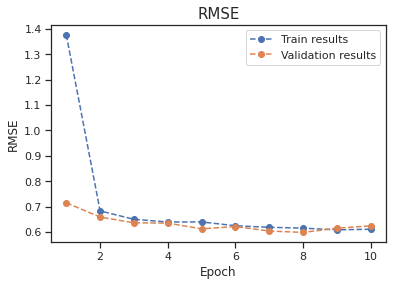

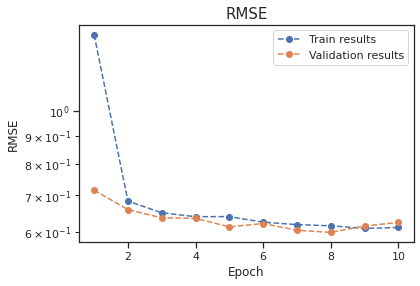

In [ ]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear')
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

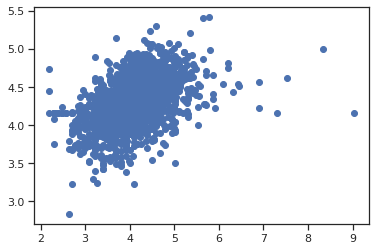

(0.44774102953267314, 4.025649390032662e-85)

In [ ]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

ys = []
ypreds = []

with torch.no_grad():
    model = model1.eval()

    for ids, labels, masks in valloader:
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model1(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


plt.scatter(ys, ypreds)
plt.show()
pearsonr(ys, ypreds)

In [ ]:

path ="/content/checkpoints/train_loss.npy"
np.save(path, train_losses)
path ="/content/checkpoints/val_loss.npy"
np.save(path, val_losses)

# do you want to save a checkpoint run this chunk
!mkdir -p /content/drive/MyDrive/Colab/airbnb/logs/reviews/TEST
!cp -r /content/checkpoints/ /content/drive/MyDrive/Colab/airbnb/logs/reviews/TEST